GBN信号生成测试

In [156]:
from scipy.signal import welch
import numpy as np
import sys
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" * 1))
sys.path.insert(0, BASE_DIR)

from setting import plt
from core.GBN_signal import gen_gbn, gen_gbn_zhu

以下是朱豫才的GBN信号代码：

按照设定样本量生成多组具有不同ETsw的GBN信号：

In [157]:
n_samples = 20000
ETsw_dict = {1: 3, 2: 5, 3: 10, 4: 30, 5: 100, 6: 200, 7: 1000}
gbn_signals = {"default": {}, "zhu": {}}

# 生成默认信号和朱豫才版本，但保持遗留变量 `gbn_signals` 指向默认集，以便下游单元格继续工作。
gbn_signals_default = {}
gbn_signals_zhu = {}

for k, ETsw in ETsw_dict.items():
    gbn_signals_default[k] = gen_gbn(n_samples=n_samples, ETsw=ETsw)
    gbn_signals_zhu[k] = gen_gbn_zhu(n_samples=n_samples, ETsw=ETsw)

画图：

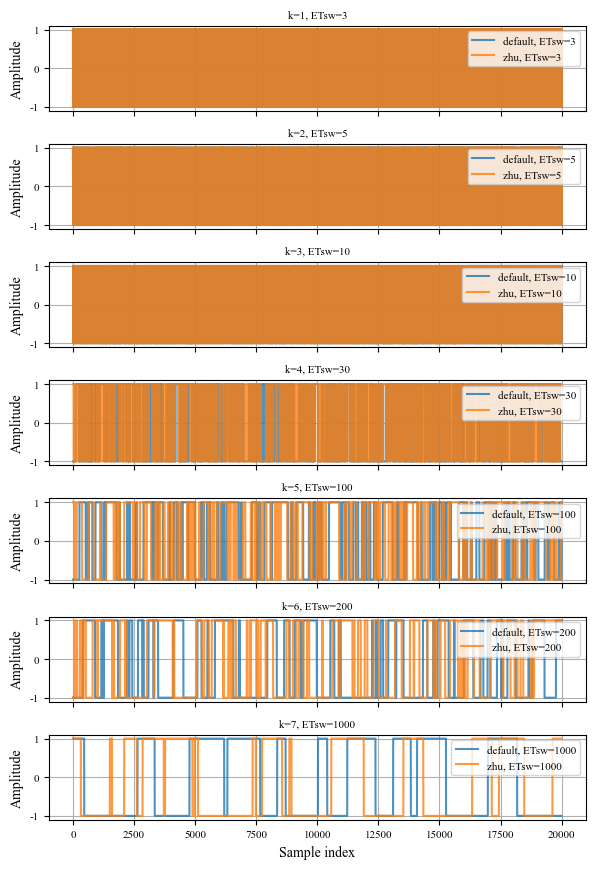

In [158]:
n_plots = len(ETsw_dict)
fig, axes = plt.subplots(nrows=n_plots, ncols=1, figsize=(6, 1.3 * n_plots), sharex=True)

# 将 axes 标准化为可迭代对象（当只有一个子图时）
if n_plots == 1:
    axes = [axes]

# 逐个子图绘制不同 ETsw 下的 default 和 zhu GBN 信号对比
for ax, k in zip(axes, ETsw_dict.keys()):
    sig_default = gbn_signals_default[k]
    sig_zhu = gbn_signals_zhu[k]
    ax.plot(sig_default, label=f"default, ETsw={ETsw_dict[k]}", alpha=0.8)
    ax.plot(sig_zhu, label=f"zhu, ETsw={ETsw_dict[k]}", alpha=0.8)
    ax.set_ylabel("Amplitude")
    ax.set_title(f"k={k}, ETsw={ETsw_dict[k]}")
    ax.legend(loc="upper right")
    ax.grid(True)

# 最后一个子图显示 x 轴标签
axes[-1].set_xlabel("Sample index")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

对比计算各信号的功率谱，首先设置功率谱计算参数：

In [ ]:
# 设置功率谱估计的参数
segment_length = 2 ** int(np.round(np.log2(max(1, n_samples / 5))))
nfft = int(segment_length * (2 ** 1))
window = np.hamming(segment_length)  # 使用 Hamming 窗
noverlap = int(round(segment_length * 0.75))  # 重叠

In [160]:
print(segment_length)
print(nfft)

4096
16384


计算PSD：

In [161]:
PSD_dict = {"default": {}, "zhu": {}}

for group in ["default", "zhu"]:
    signals = gbn_signals_default if group == "default" else gbn_signals_zhu
    for k, sig in signals.items():
        f, Pxx = welch(sig, window=window, nperseg=segment_length,
                       noverlap=noverlap, nfft=nfft)
        omega = 2 * np.pi * f / 1
        eps = np.finfo(Pxx.dtype).eps
        Pxx_safe = np.maximum(Pxx, eps)
        Pxx_f32 = Pxx_safe.astype(np.float32, copy=False)
        Pxx_dB = (10.0 * np.log10(Pxx_f32)).astype(np.float32)

        PSD_dict[group][k] = {
            "f": f,
            "omega": omega,
            "Pxx": Pxx_f32,
            "Pxx_dB": Pxx_dB,
        }

画图对比：

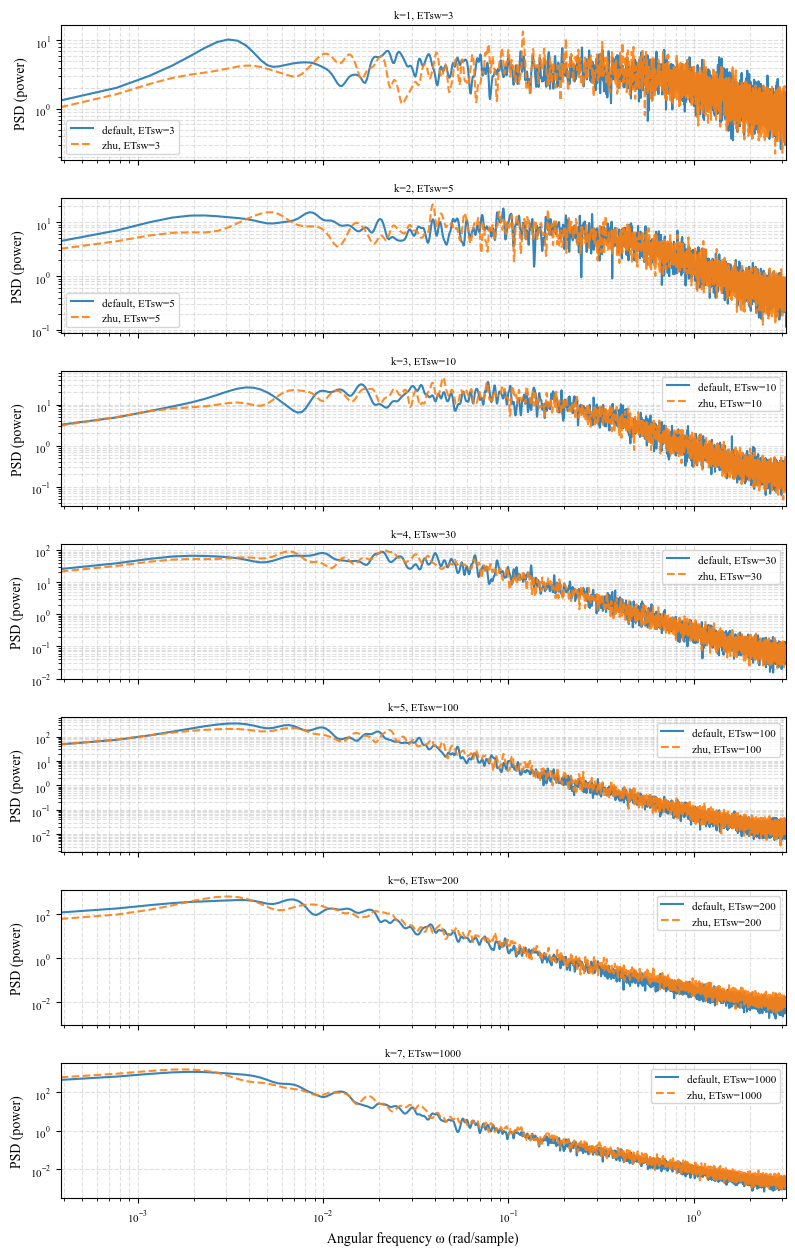

In [162]:
# 在 (0, π] 上对比绘制 default vs zhu 的 PSD（双对数坐标）
n_plots = len(ETsw_dict)
fig, axes = plt.subplots(nrows=n_plots, ncols=1, figsize=(8, 1.8 * n_plots), sharex=True)

if n_plots == 1:
    axes = [axes]

# 计算全局最小正角频率
min_pos_omega = min(
    d["omega"][d["omega"] > 0].min()
    for group_dict in PSD_dict.values()
    for d in group_dict.values()
)

for ax, k in zip(axes, ETsw_dict.keys()):
    d_def = PSD_dict["default"][k]
    d_zhu = PSD_dict["zhu"][k]

    omega_def = d_def["omega"]
    Pxx_def = d_def["Pxx"]
    omega_zhu = d_zhu["omega"]
    Pxx_zhu = d_zhu["Pxx"]

    mask_def = (omega_def > 0) & (omega_def <= np.pi)
    mask_zhu = (omega_zhu > 0) & (omega_zhu <= np.pi)

    ax.loglog(omega_def[mask_def], Pxx_def[mask_def], label=f"default, ETsw={ETsw_dict[k]}", alpha=0.9)
    ax.loglog(omega_zhu[mask_zhu], Pxx_zhu[mask_zhu], label=f"zhu, ETsw={ETsw_dict[k]}", alpha=0.9, ls="--")

    ax.set_ylabel("PSD (power)")
    ax.set_title(f"k={k}, ETsw={ETsw_dict[k]}")
    ax.grid(True, which="both", ls="--", alpha=0.4)
    ax.set_xlim(left=min_pos_omega, right=np.pi)
    ax.legend(loc="best")

axes[-1].set_xlabel("Angular frequency ω (rad/sample)")
plt.tight_layout()
plt.show()
